<a href="https://colab.research.google.com/github/eslamalaa10/fruits-360_dataset/blob/master/SVM_pattern_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**

In [3]:
# Import required libraries
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
ops.reset_default_graph()

TensorFlow 1.x selected.


In [1]:
!git clone https://github.com/eslamalaa10/fruits-360_dataset.git

import numpy as np
import os
from imutils import paths
import cv2
import pandas as pd
def load_images(path):
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(path))
  imagePaths.sort()
  data = []
  labels = []
  for imagePath in imagePaths:
    print(imagePath)
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (50, 50))
    data.append(image)
    labels.append(label)
  data = np.array(data)
  labels=pd.get_dummies(labels)
  labels = np.array(labels)
  return data,labels
x_test,y_test=load_images('/content/fruits-360_dataset/Test')
x_train,y_train=load_images('/content/fruits-360_dataset/Training')

Streaming output truncated to the last 5000 lines.
/content/fruits-360_dataset/Training/Tangelo/287_100.jpg
/content/fruits-360_dataset/Training/Tangelo/288_100.jpg
/content/fruits-360_dataset/Training/Tangelo/289_100.jpg
/content/fruits-360_dataset/Training/Tangelo/28_100.jpg
/content/fruits-360_dataset/Training/Tangelo/290_100.jpg
/content/fruits-360_dataset/Training/Tangelo/291_100.jpg
/content/fruits-360_dataset/Training/Tangelo/292_100.jpg
/content/fruits-360_dataset/Training/Tangelo/293_100.jpg
/content/fruits-360_dataset/Training/Tangelo/294_100.jpg
/content/fruits-360_dataset/Training/Tangelo/295_100.jpg
/content/fruits-360_dataset/Training/Tangelo/296_100.jpg
/content/fruits-360_dataset/Training/Tangelo/297_100.jpg
/content/fruits-360_dataset/Training/Tangelo/298_100.jpg
/content/fruits-360_dataset/Training/Tangelo/299_100.jpg
/content/fruits-360_dataset/Training/Tangelo/29_100.jpg
/content/fruits-360_dataset/Training/Tangelo/2_100.jpg
/content/fruits-360_dataset/Training/Tang

In [2]:
fruits=[]
imagePaths = list(paths.list_images('/content/fruits-360_dataset/Test'))
imagePaths.sort()

for imagePath in imagePaths:
  fruits.append(imagePath.split(os.path.sep)[-2])
fruits = list(dict.fromkeys(fruits))
print(fruits)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado ripe', 'Avocado', 'Banana Lady Finger', 'Banana Red', 'Banana', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Dates', 'Eggplant', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grape White', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon Meyer', 'Lemon', 'Limes', 'Lychee', 'Mandarine', 'Mango Red', 'Mango', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine Flat', 'Nectarine', 'Nut

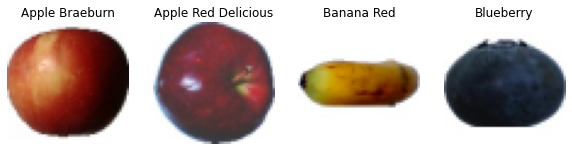

In [4]:
# Display samples of the dataset
fig, axes = plt.subplots(1, 4, figsize=(10, 3))

axes[0].set_title(fruits[(int(np.where( y_train[0] == 1)[0]))])
axes[0].imshow(x_train[0])
axes[0].axis('off')

axes[1].set_title(fruits[(int(np.where( y_train[5200] == 1)[0]))])
axes[1].imshow(x_train[5200])
axes[1].axis('off')

axes[2].set_title(fruits[(int(np.where( y_train[8200] == 1)[0]))])
axes[2].imshow(x_train[8200])
axes[2].axis('off')

axes[3].set_title(fruits[(int(np.where( y_train[9800] == 1)[0]))])
axes[3].imshow(x_train[9800])
axes[3].axis('off')
plt.show()

In [0]:
x_train.shape

(1962, 100, 100, 3)

In [0]:
# Normalize the dataset in the interval [0,1]
x_train = x_train.reshape(x_train.shape[0],50*50*3)/255.0
x_test = x_test.reshape(x_test.shape[0],50*50*3)/255.0

# **PCA**

In [3]:
from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(x_train)


PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [4]:
pca.n_components_

145

In [0]:
train_pca = pca.transform(x_train)
test_pca = pca.transform(x_test)

In [8]:
train_pca.shape

(60498, 145)

#### **Model Structure**


In [0]:
# hyperparameters
learning_rate = 0.01
epochs = 100

batch_size = 10
batches = int(x_train.shape[0] / batch_size) 

In [0]:
x=train_pca.shape[1]
y=120

In [0]:
X = tf.placeholder(tf.float32, [None, k])
Y = tf.placeholder(tf.float32, [None, y])

W = tf.Variable(tf.truncated_normal([k, y]))
B = tf.Variable(tf.zeros(y))

In [0]:
model_output = tf.matmul(X, W) + B

Multiclass SVM loss function 


In [0]:
# Declare loss function
# L2 regularization

alpha = tf.constant([0.00001])
delta = tf.constant([0.01], tf.float32)

regulation_term = alpha * tf.nn.l2_loss(W) 

S_truelabel = tf.reduce_sum(tf.multiply(Y,model_output),axis=1 ,keepdims=True)
loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, model_output - S_truelabel + delta), 1) - delta )
loss += regulation_term

In [0]:
# Declare the optimizer for optimizing the loss function
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [64]:
with tf.Session() as sesh:
    sesh.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for i in range(batches):
            offset = i * epoch
            x = train_pca[offset: offset + batch_size]
            y = y_train[offset: offset + batch_size]
            sesh.run(optimizer, feed_dict={X: x, Y:y})
            c = sesh.run(loss, feed_dict={X:x, Y:y})
            
    # Test the model
    
    correct_prediction = tf.equal(tf.argmax(sesh.run(model_output,feed_dict={X: test_pca, Y:y_test}),1), tf.argmax(y_test,1))
    accuracy_test = tf.multiply(100.0,tf.reduce_mean(tf.cast(correct_prediction, "float")))
    print('test acc',sesh.run(accuracy_test))

    prediction= tf.argmax(sesh.run(model_output,feed_dict={X: test_pca, Y:y_test}),1)

    correct_prediction = tf.equal(tf.argmax(sesh.run(model_output,feed_dict={X: train_pca, Y:y_train}),1), tf.argmax(y_train,1))
    accuracy_train = tf.multiply(100.0,tf.reduce_mean(tf.cast(correct_prediction, "float")))
    print('train acc',sesh.run(accuracy_train),'\n')
    

test acc 81.08331
train acc 99.22146 



# **Confusion Matrix**

In [68]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sesh:
  y_pred=sesh.run(prediction)
  y_pred=pd.get_dummies(y_pred)
  y_pred=np.array(y_pred)

  cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
  cm=pd.DataFrame(cm, index = [i for i in fruits],
                  columns = [i for i in fruits])
  
  print(cm)

                    Apple Braeburn  Apple Crimson Snow  ...  Tomato Yellow  Walnut
Apple Braeburn                 119                   0  ...              0       0
Apple Crimson Snow               0                 124  ...              0       0
Apple Golden 1                   0                   0  ...              0       0
Apple Golden 2                   0                   0  ...              0       0
Apple Golden 3                   0                   0  ...              0       0
...                            ...                 ...  ...            ...     ...
Tomato 4                         0                   0  ...              0       0
Tomato Cherry Red                0                   0  ...              0       0
Tomato Maroon                    0                   0  ...              0       0
Tomato Yellow                    0                   0  ...            129       0
Walnut                           0                   0  ...              0     238

[12

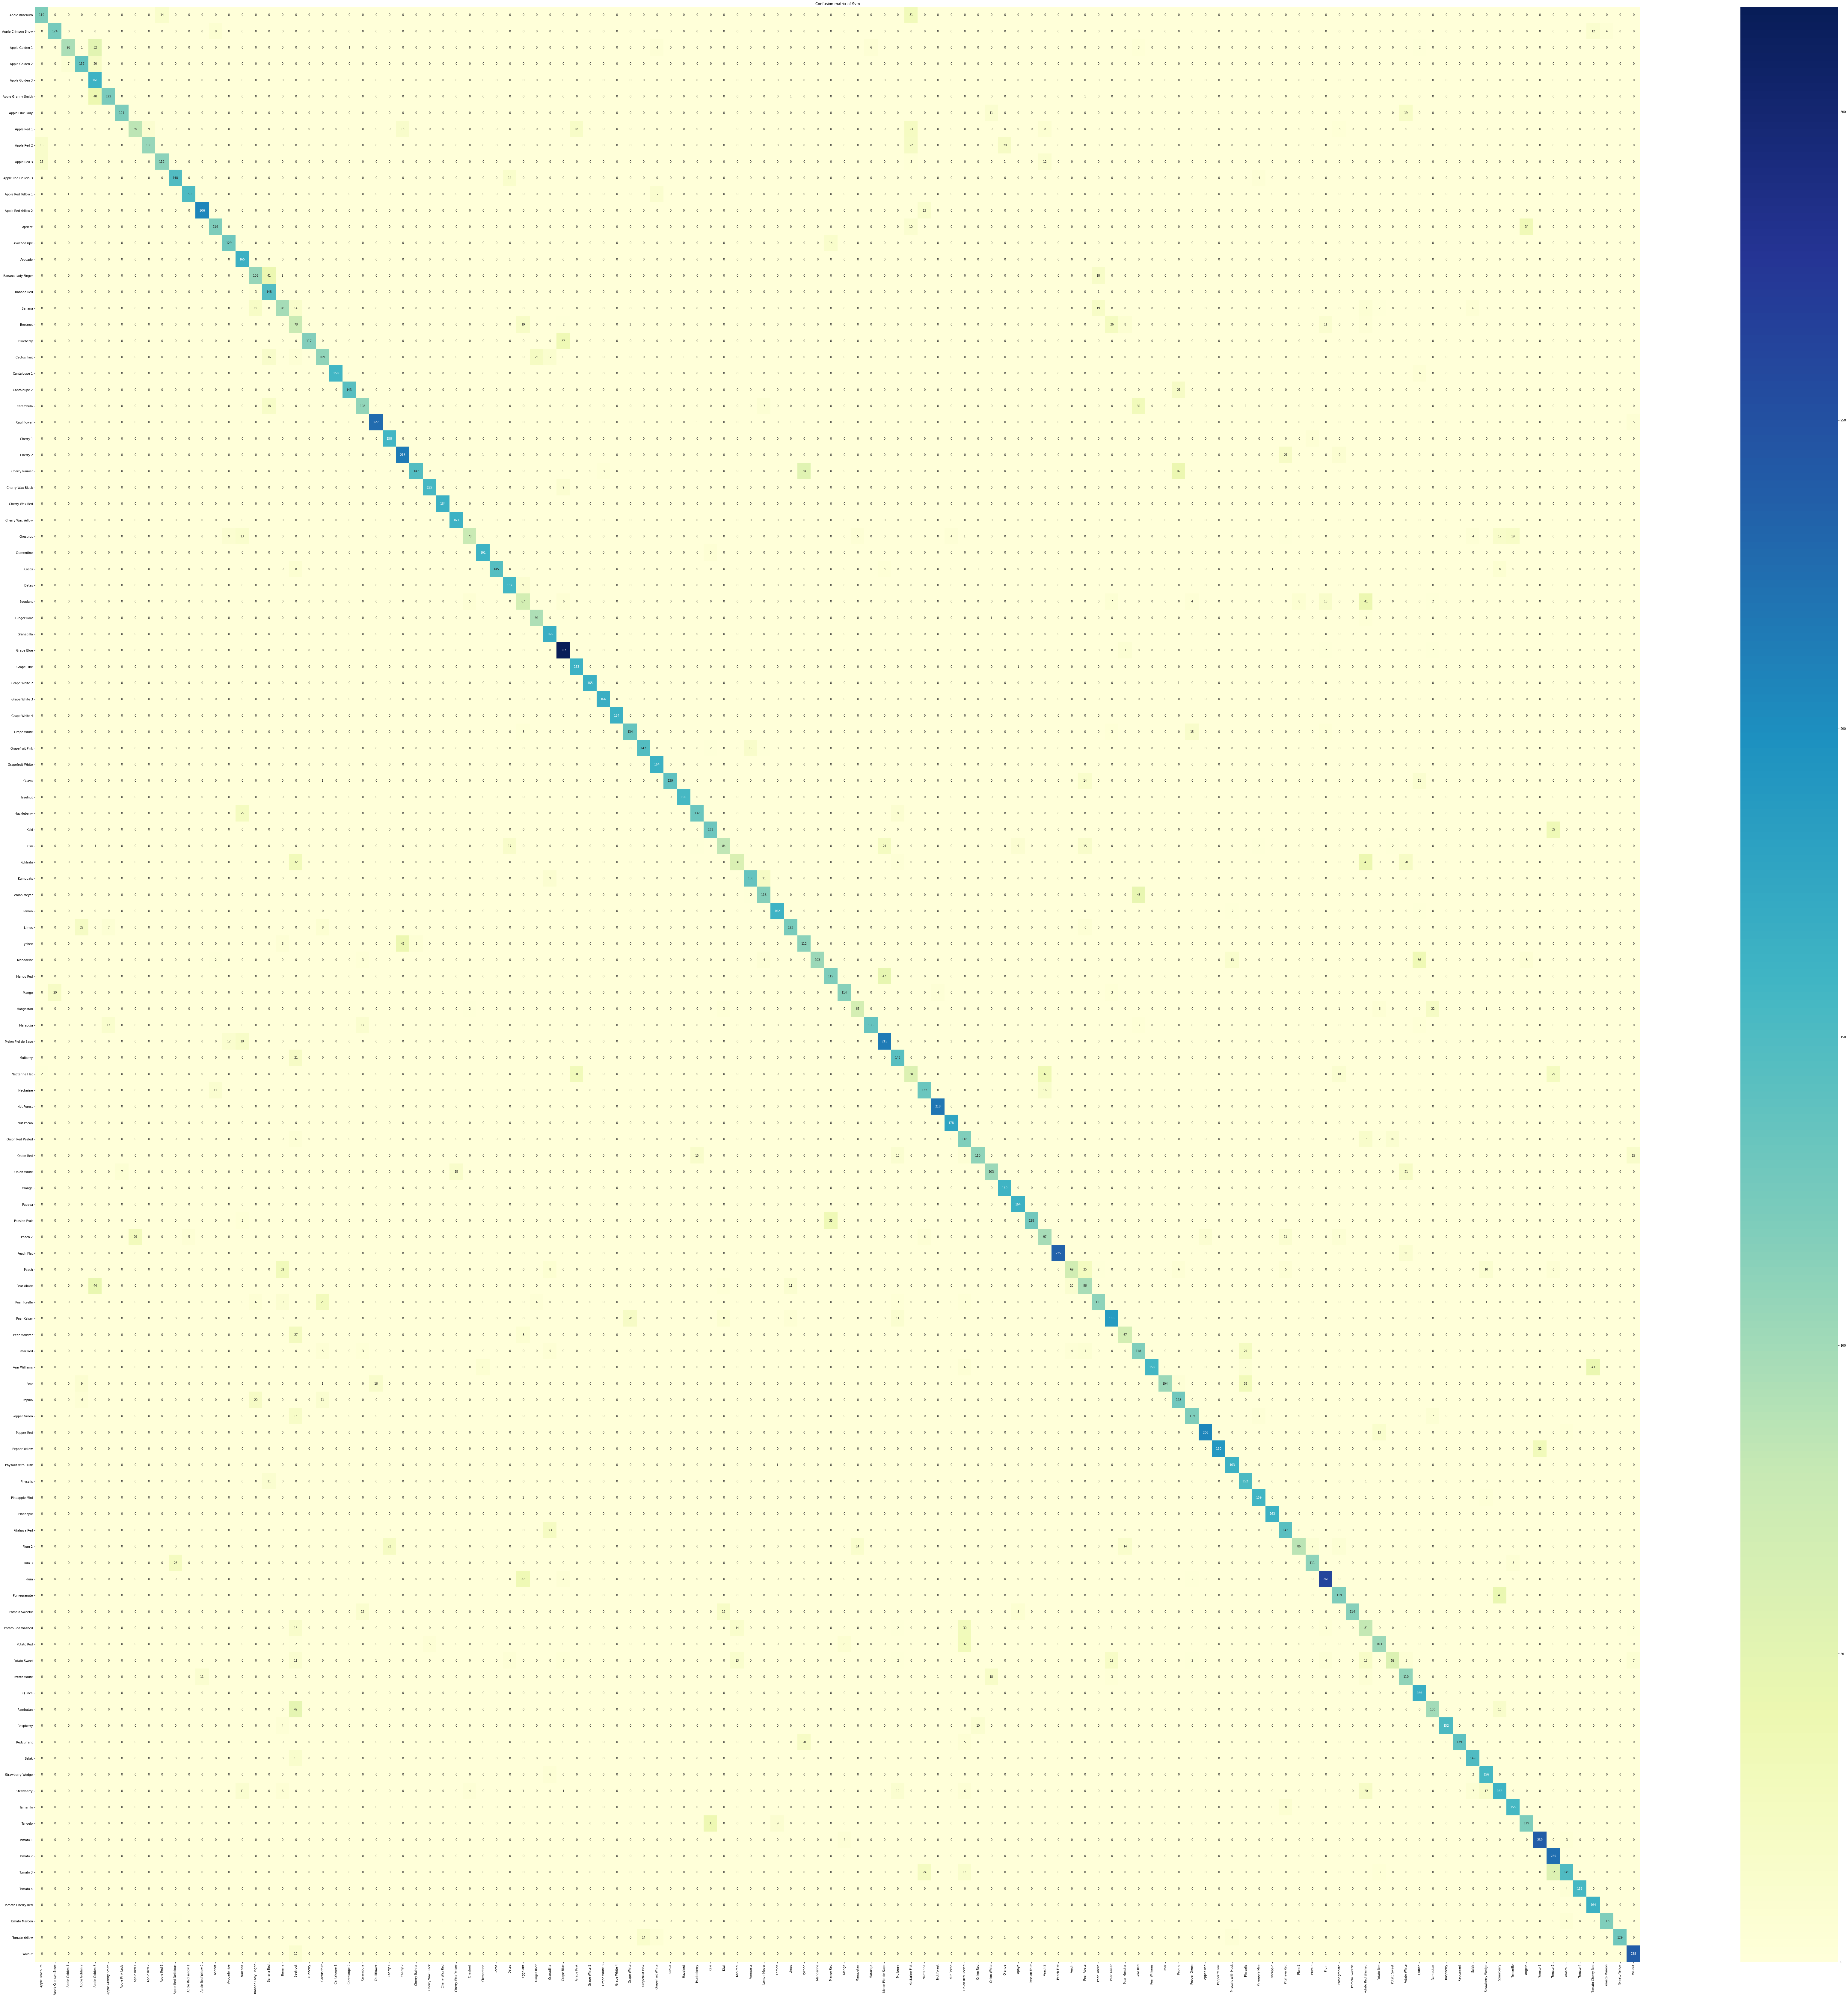

In [74]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (120,120))
plt.title('Confusion matrix of Svm')
sn.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")
plt.show()